In [1]:
from astropy.io import fits
import h5py
import healpy as hp
import matplotlib.pyplot as plt
import numpy as np

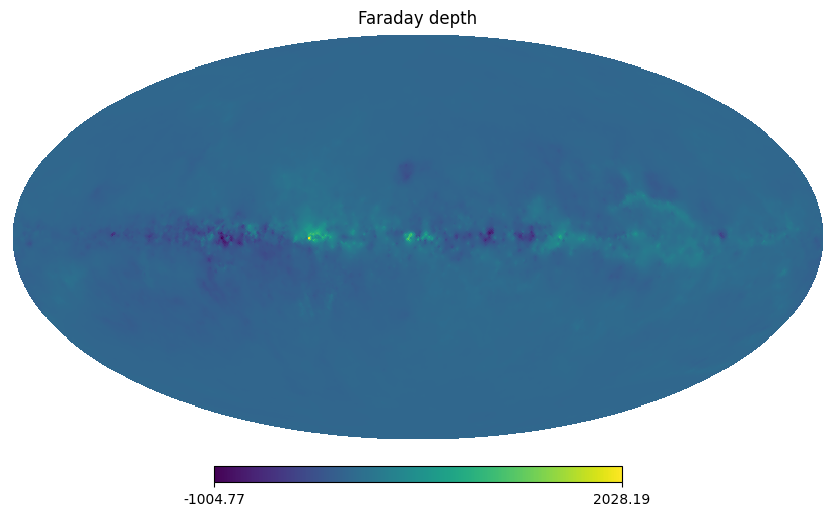

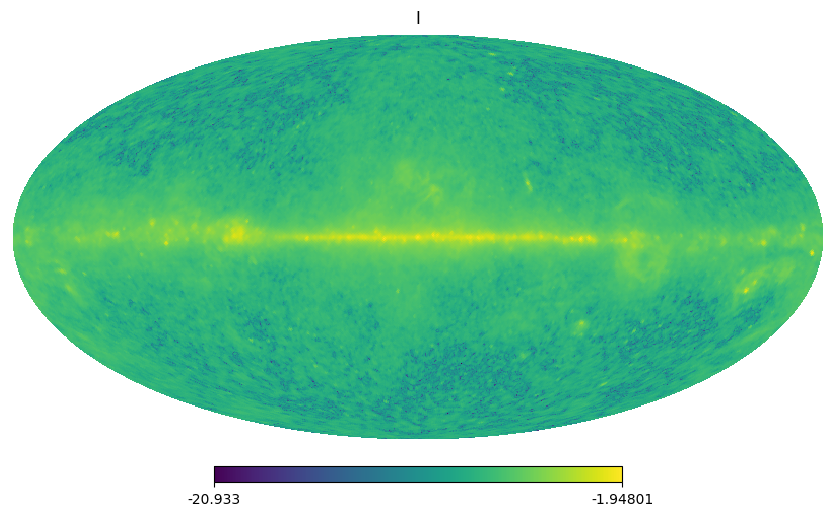

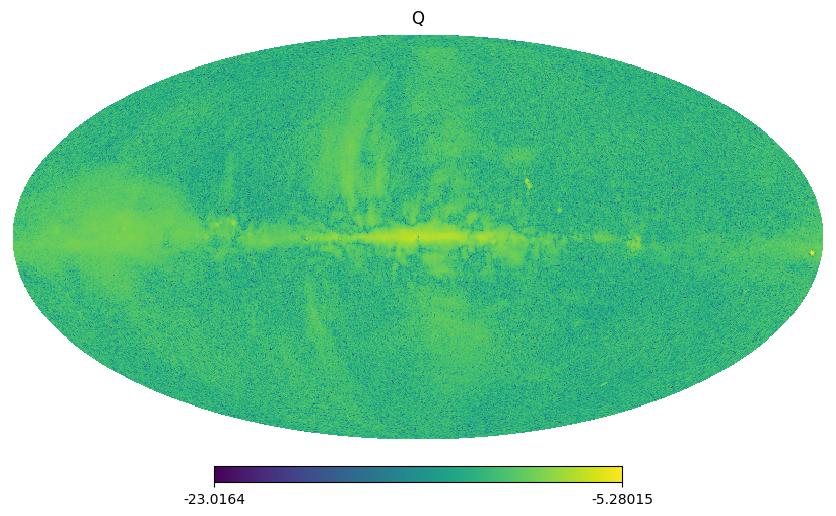

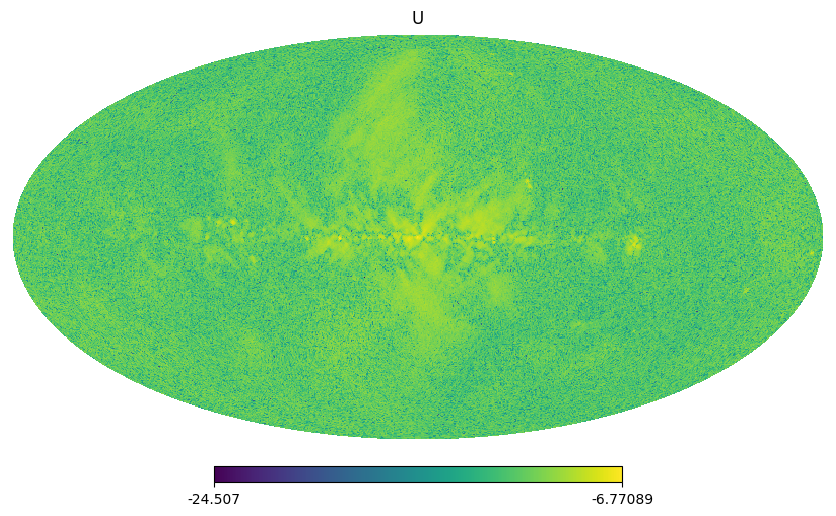

In [2]:
with h5py.File("faraday2020v2.hdf5", "r") as f:
    phi = f["faraday_sky_mean"][:]
    
with fits.open("wmap_band_iqumap_r9_9yr_K_v5.fits") as hdul:
    wmap = hdul["Stokes Maps"].data # mK
    I_wmap = wmap["TEMPERATURE"] / 1e3
    Q_wmap = wmap["Q_POLARISATION"] / 1e3
    U_wmap = wmap["U_POLARISATION"] / 1e3
    
# degrade maps
nside = 128
I_wmap = hp.ud_grade(I_wmap, nside, order_in="NEST", order_out="RING")
Q_wmap = hp.ud_grade(Q_wmap, nside, order_in="NEST", order_out="RING")
U_wmap = hp.ud_grade(U_wmap, nside, order_in="NEST", order_out="RING")
phi = hp.ud_grade(phi, nside)

hp.mollview(phi, title="Faraday depth")
hp.mollview(np.log(np.abs(I_wmap)), title="I")
hp.mollview(np.log(np.abs(Q_wmap)), title="Q")
hp.mollview(np.log(np.abs(U_wmap)), title="U")

In [3]:
# rotate maps
from croissant import rotations
from astropy.coordinates import AltAz, EarthLocation
to_frame = AltAz(location=EarthLocation(250, -30), obstime="2023-06-23T00:41")
rm = rotations.get_rot_mat("galactic", to_frame)
euler = rotations.rotmat_to_euler(rm)

In [4]:
rot = hp.Rotator(rot=euler, coord=None, deg=False, eulertype="ZYX")
I_wmap, Q_wmap, U_wmap = rot.rotate_map_alms([I_wmap, Q_wmap, U_wmap])

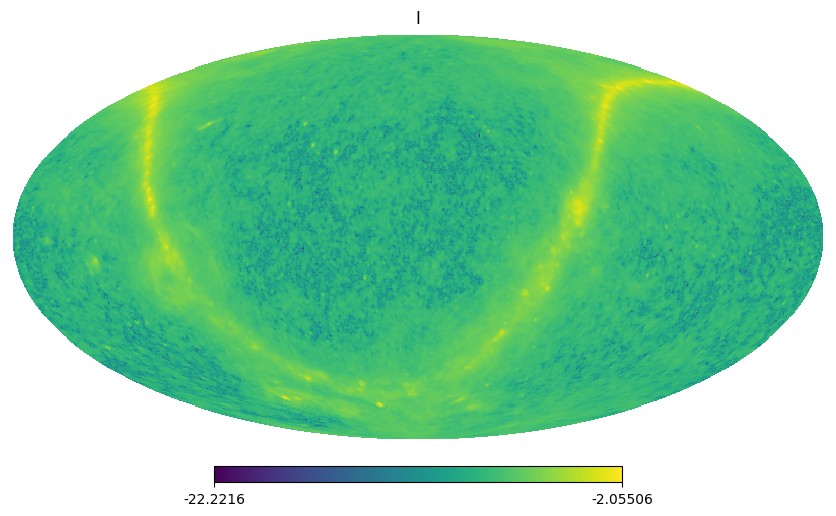

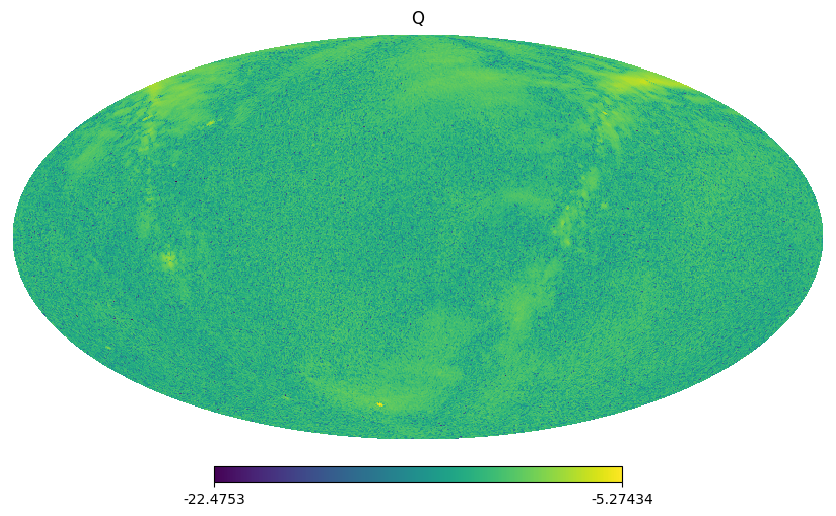

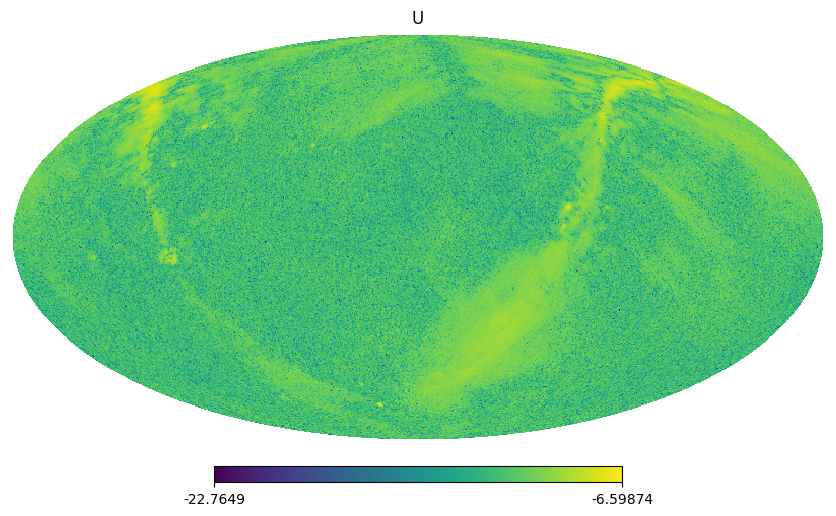

In [5]:
hp.mollview(np.log(np.abs(I_wmap)), title="I")
hp.mollview(np.log(np.abs(Q_wmap)), title="Q")
hp.mollview(np.log(np.abs(U_wmap)), title="U")

In [6]:
wmap_freq = 23e9  # Hz
width = 25e3 / 64  # channel width of zoomable region
nchans = 64
fmin = 30e6
freqs = np.linspace(0, width * (nchans-1), nchans) + fmin # Hz

# power law scaling
beta = -2.5  # spectral index
I = I_wmap[None] * (freqs/wmap_freq)[:, None]**beta
Q = Q_wmap[None] * (freqs/wmap_freq)[:, None]**beta
U = U_wmap[None] * (freqs/wmap_freq)[:, None]**beta

c = 299792458  # m/s
lambda_sq = c**2 / freqs**2
lambda_wmap = c / wmap_freq
dlambda = lambda_sq - lambda_wmap**2
chi = phi[None] * dlambda[:, None]

## Beam

In [7]:
from croissant.healpix import grid2healpix

In [8]:
with fits.open("hfss_lbl_3m_75deg.2port.fits") as hdul:
    E_theta = hdul["Etheta_real"].data + 1j * hdul["Etheta_imag"].data
    E_phi = hdul["Ephi_real"].data + 1j * hdul["Ephi_imag"].data
    ix = np.argwhere(hdul["freq"].data == 30)[0, 0]
    E_theta = E_theta[ix]
    E_phi = E_phi[ix]
E_theta = np.append(E_theta, np.zeros_like(E_theta)[:-1], axis=0)[:, :-1]  # horizon
E_phi = np.append(E_phi, np.zeros_like(E_phi)[:-1], axis=0)[:, :-1]  # horizon

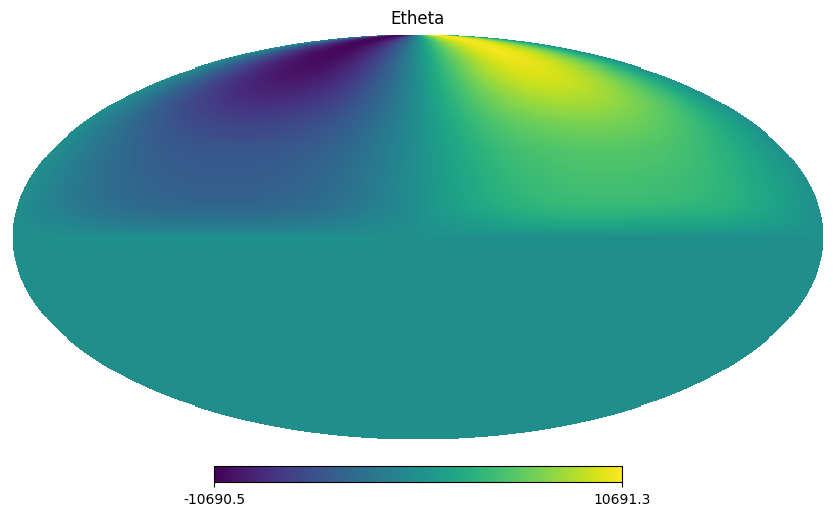

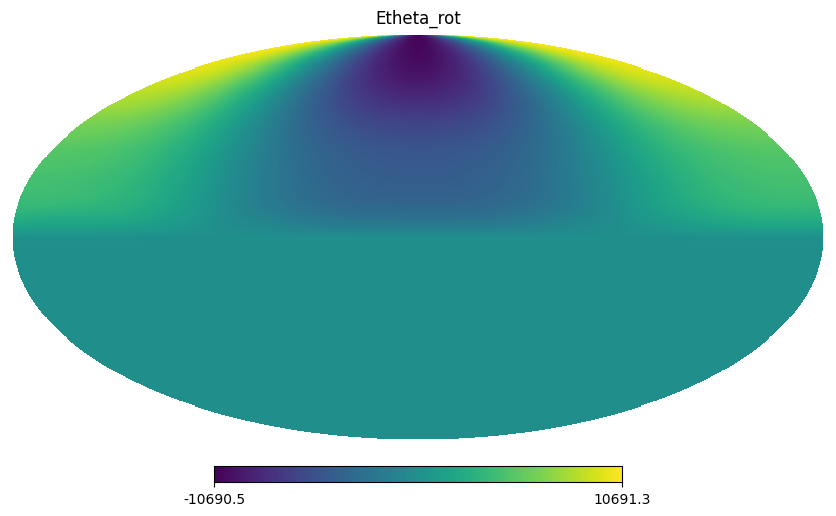

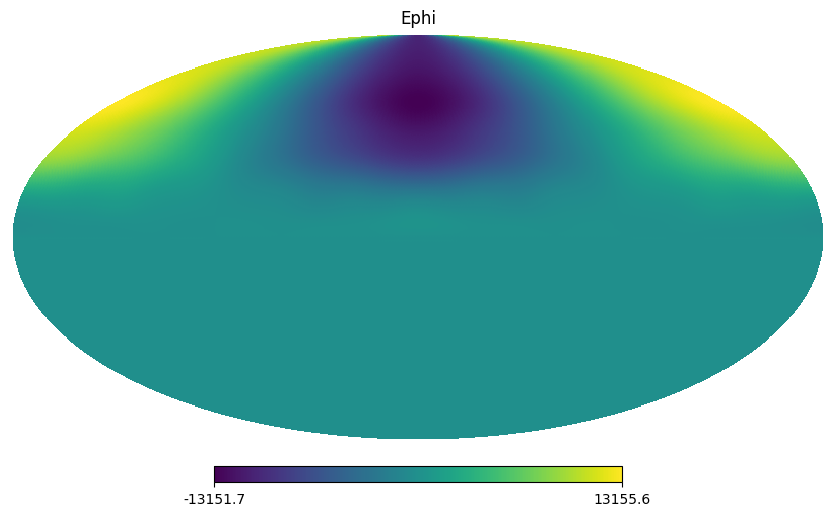

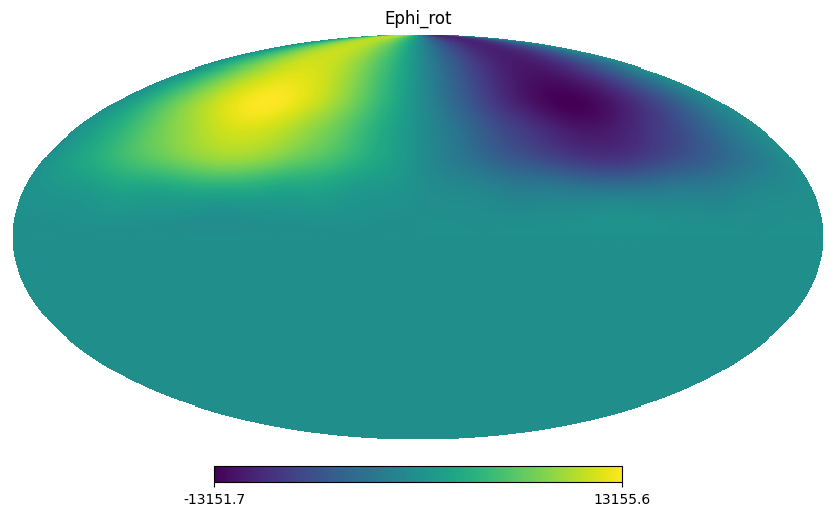

In [9]:
beam1 = grid2healpix(np.array([E_theta.real, E_theta.imag, E_phi.real, E_phi.imag]), nside)
rot = hp.Rotator(rot=90, deg=True)
beam2 = np.array([rot.rotate_map_pixel(b) for b in beam1])
hp.mollview(beam1[0], title="Etheta")
hp.mollview(beam2[0], title="Etheta_rot")
hp.mollview(beam1[2], title="Ephi")
hp.mollview(beam2[2], title="Ephi_rot")

beam1 = np.array([beam1[0] + 1j* beam1[1], beam1[2] + 1j * beam1[3]])  # Etheta, Ephi
beam2 = np.array([beam2[0] + 1j* beam2[1], beam2[2] + 1j * beam2[3]])  # Etheta, Ephirot

For orthogonal feeds (labeled 1, 2), the Stokes parameters can be measured as:

$$I = V_{11} + V_{22} \\
Q = V_{11} - V_{22} \\
U = V_{12} + V_{21} \\
V = i \left(V_{12} - V_{21}\right), $$

where

$$V_{ij} = \int \mathrm{d}\Omega A_i^a A_j^{b*} T_{ab} \\
T = \frac{1}{2} \begin{pmatrix}
I+Q & U+iV \\
U-iV & I-Q
\end{pmatrix}$$

In [10]:
def coherency(I, Q, U, faraday=False, chi=None):
    if faraday:
        P = Q + 1j * U
        P_rot = P * np.exp(2j * chi)
        Q_rot = P_rot.real
        U_rot = P_rot.imag
        T_rot = 1/2 * np.array([[I + Q_rot, U_rot], [U_rot, I - Q_rot]])
        return Q_rot, U_rot, T_rot
    else:
        return 1/2 * np.array([[I + Q, U], [U, I - Q]])
    
T = coherency(I, Q, U)
Q_rot, U_rot, T_rot = coherency(I, Q, U, faraday=True, chi=chi)

In [11]:
# normalization for visibility integrals
norm = 2 / np.sum(np.abs(beam1)**2)
npix = beam1.shape[-1]

def vis(beam1, beam2, T):
    ein = "ap, bp, ab...p"
    beams = [beam1, beam2]
    V11 = np.einsum(ein, beam1, beam1.conj(), T)
    V22 = np.einsum(ein, beam2, beam2.conj(), T)
    V12 = np.einsum(ein, beam1, beam2.conj(), T)
    v_arr = np.real([V11, V12.real, V12.imag, V22]) * norm
    return v_arr

V11, V12_real, V12_imag, V22 = vis(beam1, beam2, T)
V11_rot, V12_real_rot, V12_imag_rot, V22_rot = vis(beam1, beam2, T_rot)

In [12]:
pQ = V11 - V22
pU = 2 * V12_real

pQ_rot = V11_rot - V22_rot
pU_rot = 2 * V12_real_rot

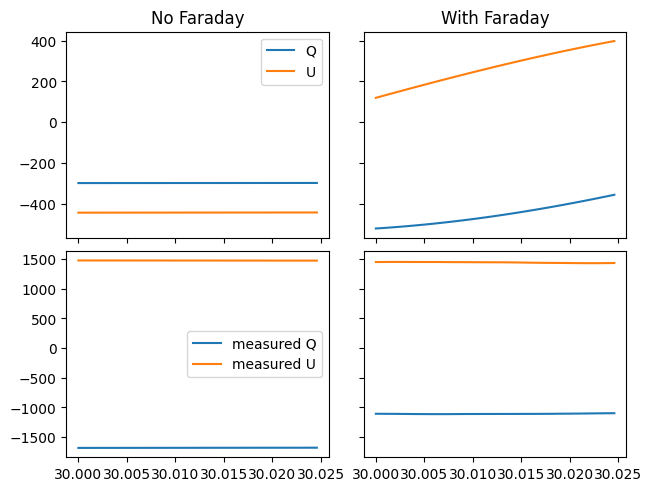

In [13]:
fig, axs = plt.subplots(nrows=2, ncols=2, sharex=True, sharey="row", constrained_layout=True)
axs[0, 0].plot(freqs / 1e6, Q[:, 0], label="Q")
axs[0, 0].plot(freqs / 1e6, U[:, 0], label="U")
axs[0, 1].plot(freqs / 1e6, Q_rot[:, 0], label="Q")
axs[0, 1].plot(freqs / 1e6, U_rot[:, 0], label="U")
axs[1, 0].plot(freqs/1e6, pQ, label="measured Q")
axs[1, 1].plot(freqs/1e6, pQ_rot, label="measured Q")
axs[1, 0].plot(freqs/1e6, pU, label="measured U")
axs[1, 1].plot(freqs/1e6, pU_rot, label="measured U")
for ax in axs[:, 0].ravel():
    ax.legend()
axs[0, 0].set_title("No Faraday")
axs[0, 1].set_title("With Faraday")
plt.show()

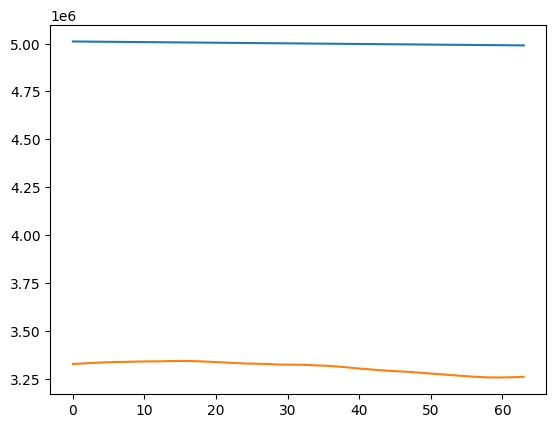

In [14]:
plt.figure()
plt.plot(pU**2 + pQ**2)
plt.plot(pU_rot**2 + pQ_rot**2)
plt.show()

## One polarized source

In [15]:
width = 25e3 / 64 # channel width of zoomable region
nchans = 64
fmin = 30e6
freqs = np.linspace(0, width * (nchans-1), nchans) + fmin # Hz

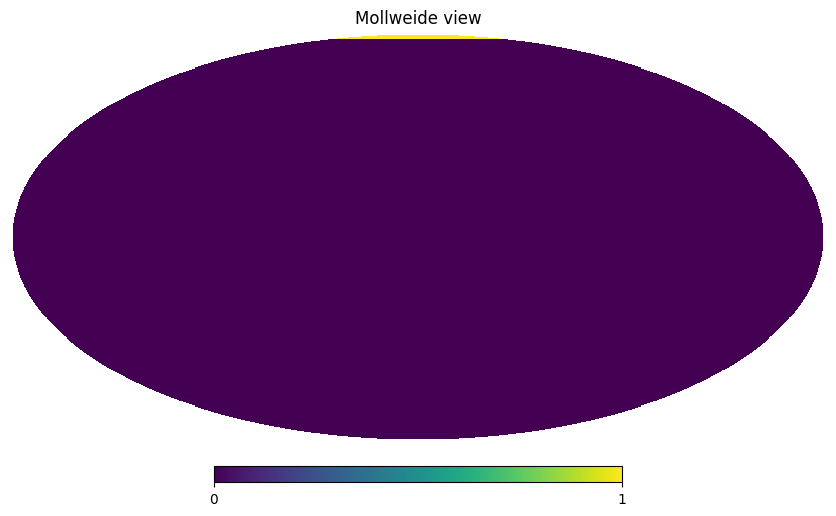

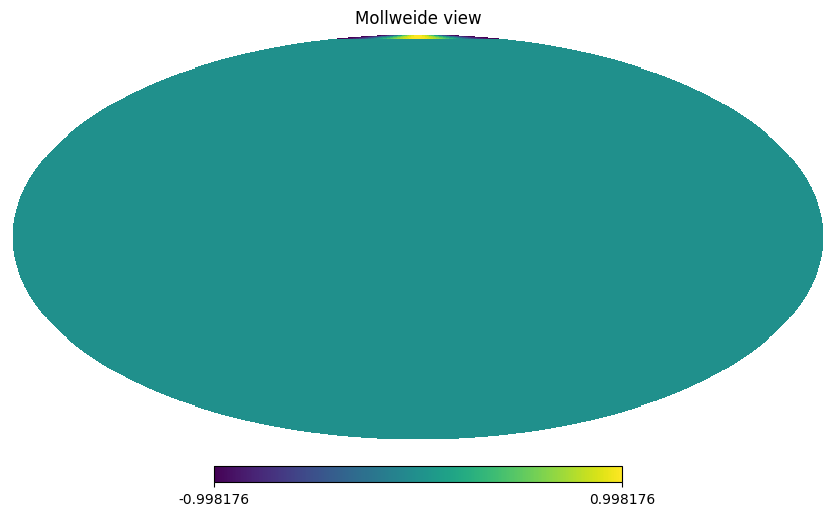

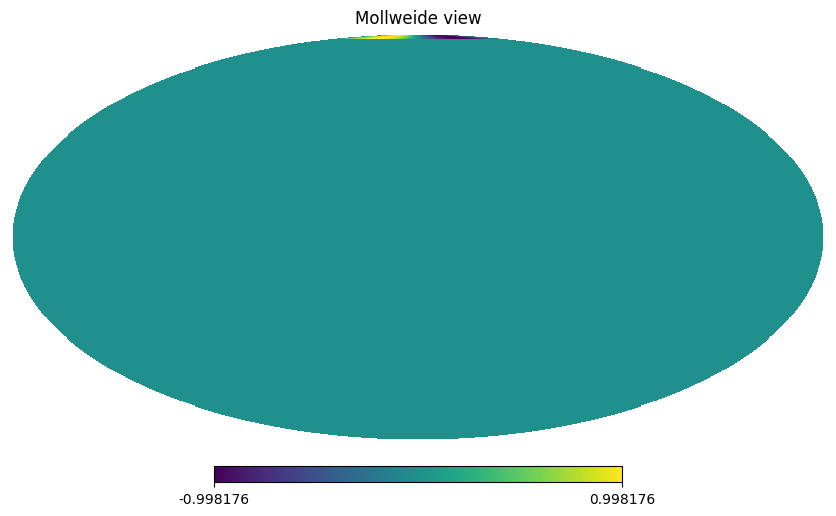

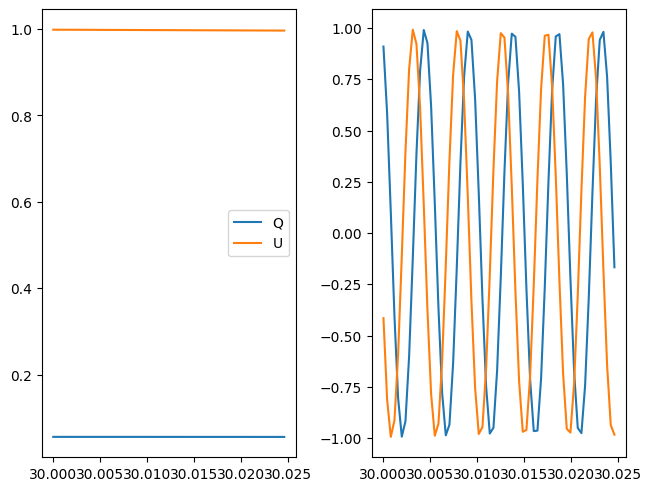

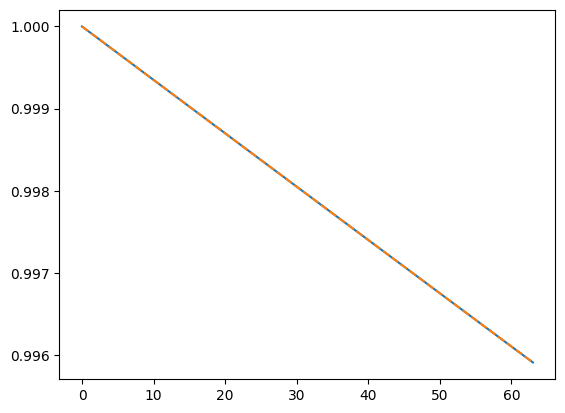

In [16]:
# Linearly polarized source with I = Q and U = V = 0. The source is at theta > 5 deg.
EXTENT = 5  # theta max of spherical cap (degrees)
nside = hp.npix2nside(npix)
src = hp.ang2pix(nside, np.linspace(0, 360, endpoint=False), 90-EXTENT, lonlat=True).max()
src_pix = np.arange(src+1)
src_th, src_ph = hp.pix2ang(nside, src_pix)
pl = (freqs / freqs[0]) ** (-2.5)
U = np.zeros(npix)
I = U.copy()
Q = U.copy()
I[src_pix] = 1
Q[src_pix] = np.cos(src_ph)
U[src_pix] = np.sin(src_ph)

I = I[None] * pl[:, None]
Q = Q[None] * pl[:, None]
U = U[None] * pl[:, None]

P = Q + 1j * U

hp.mollview(I[0])
hp.mollview(Q[0])
hp.mollview(U[0])

RM = 100 * I[0]
chi = RM[None] * dlambda[:, None]
# P_rot = P * np.exp(1j * 2 * chi)
# Q_rot = P_rot.real
# U_rot = P_rot.imag
T = coherency(I, Q, U)
Q_rot, U_rot, T_rot = coherency(I, Q, U, faraday=True, chi=chi)

fig, axs = plt.subplots(ncols=2, sharex=True, sharey=False, constrained_layout=True)
ix = 377
axs[0].plot(freqs / 1e6, Q[:, ix], label="Q")
axs[0].plot(freqs / 1e6, U[:, ix], label="U")
axs[0].legend()
axs[1].plot(freqs / 1e6, Q_rot[:, ix])
axs[1].plot(freqs / 1e6, U_rot[:, ix])
#axs[2].plot(freqs / 1e6, np.abs(P[:, 0])**2)
#axs[2].plot(freqs / 1e6, np.abs(P_rot[:, 0])**2, ls="--")
plt.show()

plt.figure()
plt.plot(Q[:, 0] **2 + U[:, 0] **2)
plt.plot(Q_rot[:, 0] **2 + U_rot[:, 0] **2, ls="--")
plt.show()

In [17]:
# T = 1/2 * np.array([[I + Q, U], [U, I-Q]])
# T_rot = 1/2 * np.array([[I + Q_rot, U_rot], [U_rot, I - Q_rot]])

V11, V12_real, V12_imag, V22 = vis(beam1, beam2, T)
V11_rot, V12_real_rot, V12_imag_rot, V22_rot = vis(beam1, beam2, T_rot)

pI = (V11 + V22) / 2
pQ = (V11 - V22) / 2
pU = V12_real

pI_rot = (V11_rot + V22_rot) / 2
pQ_rot = (V11_rot - V22_rot) / 2
pU_rot = V12_real_rot

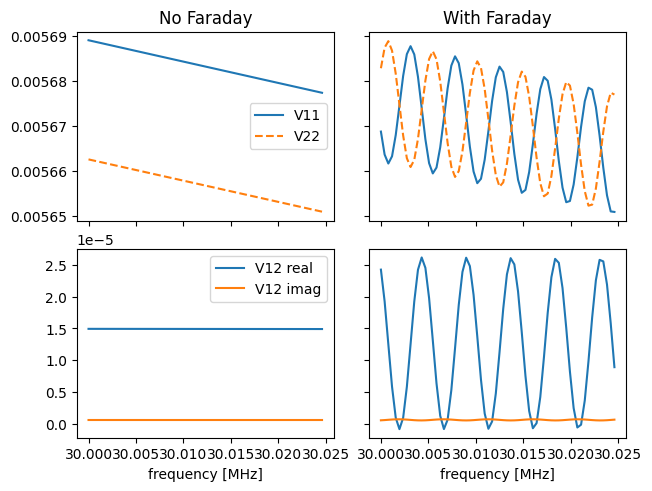

In [18]:
fig, axs = plt.subplots(nrows=2, ncols=2, sharex=True, sharey="row", constrained_layout=True)
axs[0, 0].plot(freqs / 1e6, V11, c="C0", label="V11")
axs[0, 0].plot(freqs / 1e6, V22, ls="--", c="C1", label="V22")
axs[0, 1].plot(freqs / 1e6, V11_rot, c="C0")
axs[0, 1].plot(freqs / 1e6, V22_rot, c="C1", ls="--")
axs[1, 0].plot(freqs / 1e6, V12_real, label="V12 real")
axs[1, 0].plot(freqs / 1e6, V12_imag, label="V12 imag")
axs[1, 1].plot(freqs / 1e6, V12_real_rot)
axs[1, 1].plot(freqs / 1e6, V12_imag_rot)
for ax in axs[:, 0].ravel():
    ax.legend()
axs[0, 0].set_title("No Faraday")
axs[0, 1].set_title("With Faraday")
for ax in axs[1]:
    ax.set_xlabel("frequency [MHz]")
plt.show()

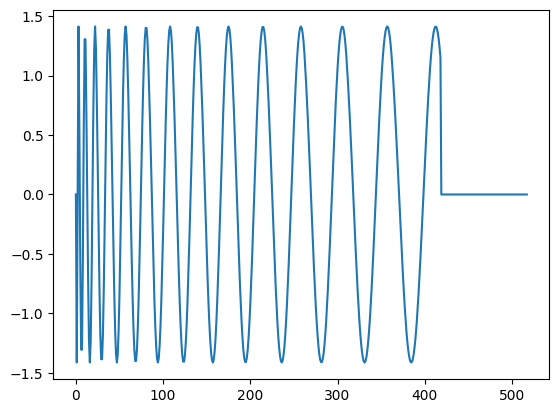

In [19]:
plt.figure()
plt.plot(np.mean(Q-U, axis=0)[:src+100])
plt.show()

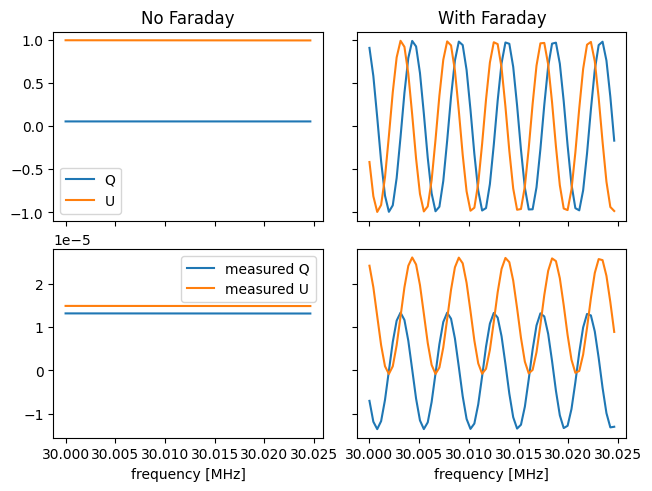

In [20]:
fig, axs = plt.subplots(nrows=2, ncols=2, sharex=True, sharey="row", constrained_layout=True)
axs[0, 0].plot(freqs / 1e6, Q[:, ix], label="Q")
axs[0, 0].plot(freqs / 1e6, U[:, ix], label="U")
axs[0, 1].plot(freqs / 1e6, Q_rot[:, ix], label="Q")
axs[0, 1].plot(freqs / 1e6, U_rot[:, ix], label="U")
axs[1, 0].plot(freqs/1e6, pQ, label="measured Q")
axs[1, 1].plot(freqs/1e6, pQ_rot, label="measured Q")
axs[1, 0].plot(freqs/1e6, pU, label="measured U")
axs[1, 1].plot(freqs/1e6, pU_rot, label="measured U")
for ax in axs[:, 0].ravel():
    ax.legend()
axs[0, 0].set_title("No Faraday")
axs[0, 1].set_title("With Faraday")
for ax in axs[1]:
    ax.set_xlabel("frequency [MHz]")
plt.show()

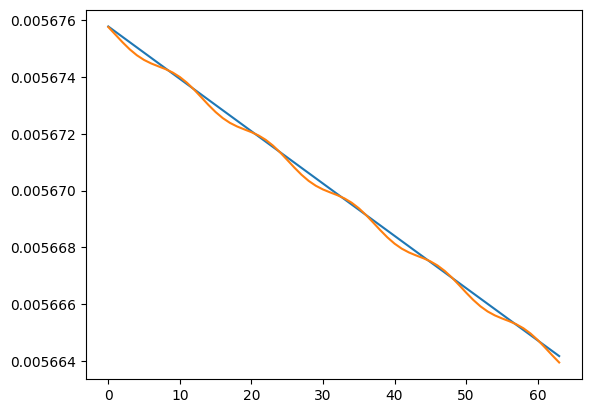

In [21]:
plt.figure()
plt.plot(pI)
plt.plot(pI_rot)
plt.show()

## Spectrometer response

In [22]:
spec4 = np.loadtxt("zoom_response_4tap.txt")
spec8 = np.loadtxt("zoom_response_8tap.txt")
offset = spec4[:, 0] * 1e3  # spacing in Hz

# normalize response
zoom4 = spec4[:, 1:] / spec4[:, 1:].sum(axis=0, keepdims=True)
zoom8 = spec8[:, 1:] / spec8[:, 1:].sum(axis=0, keepdims=True)

In [35]:
fmin = 30e6  # start frequency
diff = 25e3
nchans = 64
chans = np.linspace(0, diff, nchans) + fmin # Hz
freqs = chans[None, :] + offset[:, None]

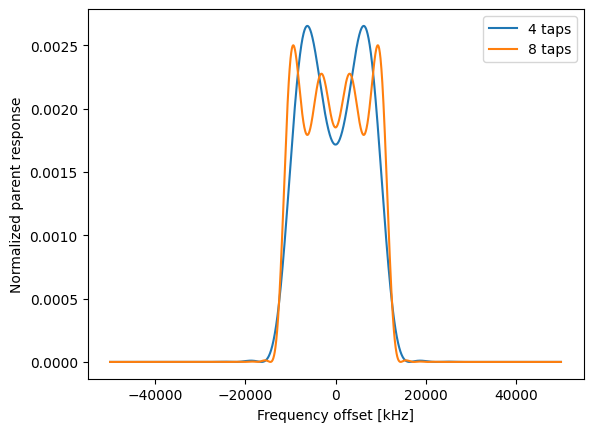

In [24]:
plt.figure()
plt.plot(offset, zoom4[:, 0], label="4 taps")
plt.plot(offset, zoom8[:, 0], label="8 taps")
plt.xlabel("Frequency offset [kHz]")
plt.ylabel("Normalized parent response")
#plt.xlim(-15, 15)
plt.legend()
plt.show()

In [25]:
nside = 64
npix = hp.nside2npix(nside)
phi = hp.ud_grade(phi, nside)
beam1 = hp.ud_grade(beam1, nside)
beam2 = hp.ud_grade(beam2, nside)

c = 299792458  # m/s
lambda_sq = c**2 / freqs**2
lambda_wmap = c**2 / wmap_freq**2
dlambda = lambda_sq - lambda_wmap

In [26]:
# Linearly polarized source with I = Q and U = V = 0. The source is at theta > 5 deg.
EXTENT = 5  # theta max of spherical cap (degrees)
#nside = hp.npix2nside(npix)
npix_src = hp.ang2pix(nside, np.linspace(0, 360, endpoint=False), 90-EXTENT, lonlat=True).max() + 1
src_pix = np.arange(npix_src)
th, ph = hp.pix2ang(nside, src_pix)
pl = np.array((freqs / freqs[0]) ** (-2.5), dtype=np.float32)

# these are healpix maps of same nside as the beams with the 0s omitted (since there's only one source)
I = np.ones(npix_src, dtype=np.float32)
Q = np.cos(ph).astype(np.float32)
U = np.sin(ph).astype(np.float32)

RM = 100 * I

I = I[None, None] * pl[:, :, None]
Q = Q[None, None] * pl[:, :, None]
U = U[None, None] * pl[:, :, None]

P = Q + 1j * U
chi = RM[None, None] * dlambda[:, :, None]
T = coherency(I, Q, U)
Q_rot, U_rot, T_rot = coherency(I, Q, U, faraday=True, chi=chi)

In [27]:
beam1 = beam1[:, :npix_src]
beam2 = beam2[:, :npix_src]

In [66]:
def vis(beam1, beam2, T, spec=None):
    """
    Compute visibilities for Lusee given two orthogonal beams and a coherency matrix. Optionally, include
    the spectrometer response.
    
    Parameters
    ----------
    beam1 : np.ndarray
        Antenna beam response. Shape (2, npix) where the rows are the theta and phi components respectively.
    beam2 : np.ndarray
        Like beam1 for the orthogonal antenna.
    T : np.ndarray
        Coherency matrix of the sky of the form [[I+Q, U], [U, I-Q]] (V=0). Shape (2, 2, [nfreqs,] nchans, npix).
    spec: np.ndarray
        Spectrometer response. Shape (nfreqs, nchans).
        
    Returns
    -------
    v_arr : np.ndarray
        The simulated visibilities in order V11, V12_real, V12_imag, V22.
        
    Notes
    -----
    Here, ``nfreqs'' is the number of simulation frequencies and ``nchans'' are the number of spectrometer channels.
        
    """
    ein = "ap, bp, ab...p"
    norm = 2 / np.sum(np.abs(beam1)**2)
    beams = [beam1, beam2]
    V11 = np.einsum(ein, beam1, beam1.conj(), T)
    V22 = np.einsum(ein, beam2, beam2.conj(), T)
    V12 = np.einsum(ein, beam1, beam2.conj(), T)
    v_arr = np.real([V11, V12.real, V12.imag, V22]) * norm
    
    if spec is not None:
        v_arr = np.sum(v_arr * spec[None], axis=1)
        
    return v_arr

In [71]:
def vis2stokes(vis_arr):
    """
    Convert simulated visibilities to Stokes parameters.
    
    Parameters
    -----------
    vis_arr: np.ndarray
        Visibilities in the order V11, V12_real, V12_imag, V22. Shape (4, nfreqs, nchans).
        
    Returns
    -------
    stokes : np.ndarray
        The Stokes parameters I, Q, and U (no V for now). 
     
    """
    V11, V12_real, V12_imag, V22 = vis_arr
    
    pI = (V11 + V22) / 2
    pQ = (V11 - V22) / 2
    pU = V12_real
    stokes = np.array([pI, pQ, pU])
    
    return stokes

In [72]:
vis4 = vis(beam1, beam2, T, spec=zoom4[:, 1:])
vis4_rot = vis(beam1, beam2, T_rot, spec=zoom4[:, 1:])

stokes4 = vis2stokes(vis4)
stokes4_rot = vis2stokes(vis4_rot)

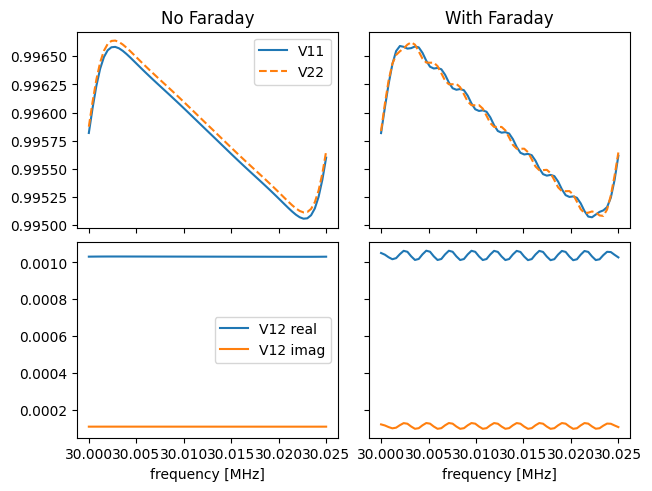

In [75]:
fig, axs = plt.subplots(nrows=2, ncols=2, sharex=True, sharey="row", constrained_layout=True)
axs[0, 0].plot(chans/1e6, vis4[0], c="C0", label="V11")
axs[0, 0].plot(chans/1e6, vis4[3], ls="--", c="C1", label="V22")
axs[0, 1].plot(chans/1e6, vis4_rot[0], c="C0")
axs[0, 1].plot(chans/1e6, vis4_rot[3], c="C1", ls="--")
axs[1, 0].plot(chans/1e6, vis4[1], label="V12 real")
axs[1, 0].plot(chans/1e6, vis4[2], label="V12 imag")
axs[1, 1].plot(chans/1e6, vis4_rot[1])
axs[1, 1].plot(chans/1e6, vis4_rot[2])
for ax in axs[:, 0].ravel():
    ax.legend()
axs[0, 0].set_title("No Faraday")
axs[0, 1].set_title("With Faraday")
for ax in axs[1]:
    ax.set_xlabel("frequency [MHz]")
plt.show()

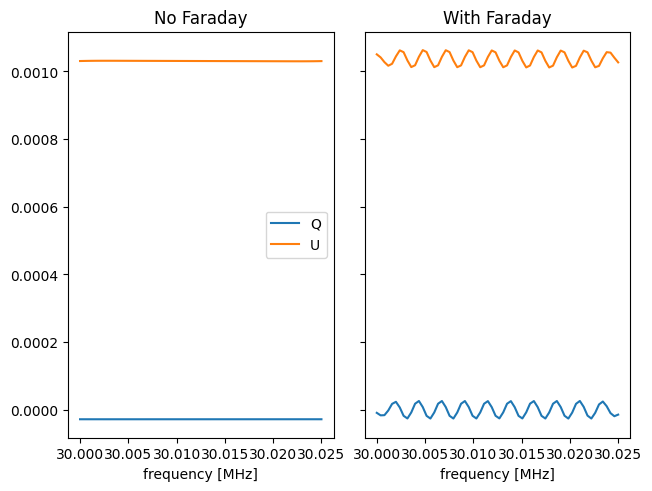

In [76]:
fig, axs = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, constrained_layout=True)
axs[0].plot(chans/1e6, stokes4[1], label="Q")
axs[1].plot(chans/1e6, stokes4_rot[1], label="Q")
axs[0].plot(chans/1e6, stokes4[2], label="U")
axs[1].plot(chans/1e6, stokes4_rot[2], label="U")
axs[0].legend()
axs[0].set_title("No Faraday")
axs[1].set_title("With Faraday")
for ax in axs:
    ax.set_xlabel("frequency [MHz]")
plt.show()

In [77]:
vis8 = vis(beam1, beam2, T, spec=zoom8[:, 1:])
vis8_rot = vis(beam1, beam2, T_rot, spec=zoom8[:, 1:])

stokes8 = vis2stokes(vis8)
stokes8_rot = vis2stokes(vis8_rot)

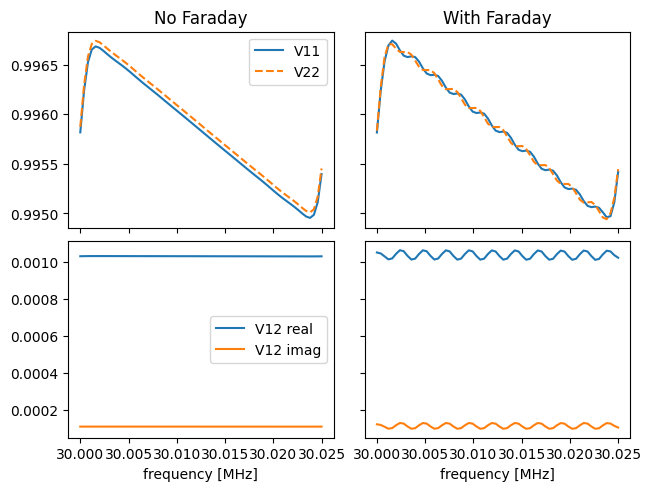

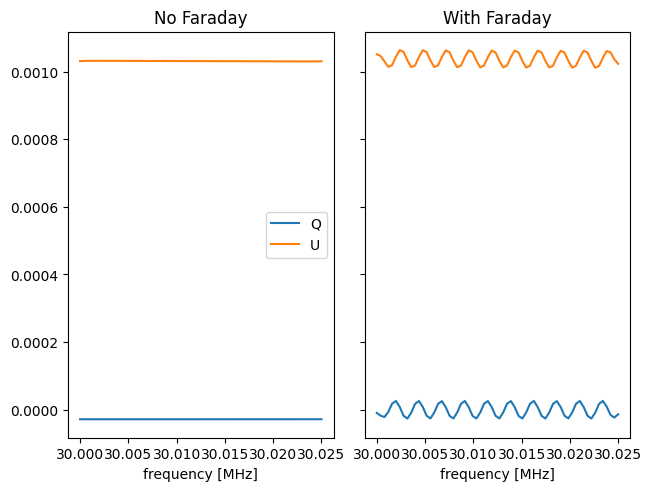

In [80]:
fig, axs = plt.subplots(nrows=2, ncols=2, sharex=True, sharey="row", constrained_layout=True)
axs[0, 0].plot(chans/1e6, vis8[0], c="C0", label="V11")
axs[0, 0].plot(chans/1e6, vis8[3], ls="--", c="C1", label="V22")
axs[0, 1].plot(chans/1e6, vis8_rot[0], c="C0")
axs[0, 1].plot(chans/1e6, vis8_rot[3], c="C1", ls="--")
axs[1, 0].plot(chans/1e6, vis8[1], label="V12 real")
axs[1, 0].plot(chans/1e6, vis8[2], label="V12 imag")
axs[1, 1].plot(chans/1e6, vis8_rot[1])
axs[1, 1].plot(chans/1e6, vis8_rot[2])
for ax in axs[:, 0].ravel():
    ax.legend()
axs[0, 0].set_title("No Faraday")
axs[0, 1].set_title("With Faraday")
for ax in axs[1]:
    ax.set_xlabel("frequency [MHz]")
plt.show()


fig, axs = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, constrained_layout=True)
axs[0].plot(chans/1e6, stokes8[1], label="Q")
axs[1].plot(chans/1e6, stokes8_rot[1], label="Q")
axs[0].plot(chans/1e6, stokes8[2], label="U")
axs[1].plot(chans/1e6, stokes8_rot[2], label="U")
axs[0].legend()
axs[0].set_title("No Faraday")
axs[1].set_title("With Faraday")
for ax in axs:
    ax.set_xlabel("frequency [MHz]")
plt.show()

## 25 kHz bins

In [ ]:
fmin = 30e6  # start frequency
diff = 25e3
nchans = 64
chans = np.linspace(0, diff*nchans, nchans) + fmin # Hz
freqs = chans[None, :] + offset[:, None]

lambda_sq = c**2 / freqs**2
lambda_wmap = c**2 / wmap_freq**2
dlambda = lambda_sq - lambda_wmap

# --------

In [ ]:
bI = 1/2 * (np.abs(E_theta)**2 + np.abs(E_phi)**2)
bQ = 1/2 * (np.abs(E_theta)**2 - np.abs(E_phi)**2)
corr = E_theta * E_phi.conj()
bU = corr.real
bV = corr.imag
beam = grid2healpix(np.array([bI, bQ, bU, bV]), nside)
hp.mollview(beam[0], title="I")
hp.mollview(beam[1], title="Q")
hp.mollview(beam[2], title="U")
hp.mollview(beam[3], title="V")

In [ ]:
beamQ = beam[1]
beamU = beam[2]

In [ ]:
fig, axs = plt.subplots(figsize=(7,5), ncols=2, sharex=True, sharey=False, constrained_layout=True)
axs[0].plot(freqs/1e6, np.mean(Q * beamQ, axis=1), label="Q")
axs[0].plot(freqs/1e6, np.mean(U * beamU, axis=1), label="U")
axs[1].plot(freqs/1e6, np.mean(Q_rot * beamQ, axis=1), label="Q")
axs[1].plot(freqs/1e6, np.mean(U_rot * beamQ, axis=1), label="U")
axs[1].legend()
axs[0].set_ylabel("T [K]")
axs[0].set_title("Original mean spectra")
axs[1].set_title("After Faraday rotation")
plt.setp(axs, xlabel="Frequency [MHz]")
plt.show()


fig, axs = plt.subplots(figsize=(7,5), ncols=2, sharex=True, sharey=True, constrained_layout=True)
axs[0].plot(lambda_sq, np.mean(Q * beamQ, axis=1), label="Q")
axs[0].plot(lambda_sq, np.mean(U * beamU, axis=1), label="U")
axs[1].plot(lambda_sq, np.mean(Q_rot * beamQ, axis=1), label="Q")
axs[1].plot(lambda_sq, np.mean(U_rot * beamQ, axis=1), label="U")
axs[1].legend()
axs[0].set_ylabel("T [K]")
axs[0].set_title("Original mean spectra")
axs[1].set_title("After Faraday rotation")
plt.setp(axs, xlabel="$\\lambda^2$ [$\\rm{m}^2$]")
plt.show()

In [ ]:
plt.figure()
plt.plot(freqs/1e6, np.mean(Q_rot * beamQ, axis=1), label="Q")
plt.plot(freqs/1e6, np.mean(U_rot * beamU, axis=1), label="U")
plt.legend()
plt.ylabel("T [K]")
plt.title("After Faraday rotation")
plt.xlabel("Frequency [MHz]")
#plt.ylim(-4, 4)
plt.show()


fft_freqs = np.fft.rfftfreq(freqs.size, (freqs[1]-freqs[0])/1e6)
fft_Q = np.fft.rfft(np.mean(Q_rot * beamQ, axis=1))  # replace with beam integral
fft_U = np.fft.rfft(np.mean(U_rot * beamU, axis=1))
plt.figure()
plt.plot(fft_freqs, np.abs(fft_Q), label="Q")
plt.plot(fft_freqs, np.abs(fft_U), label="U")
plt.legend()
plt.ylabel("T [K]")
plt.title("After Faraday rotation")
plt.xlabel("Delay [us]")
#plt.ylim(-4, 4)
plt.show()

In [ ]:
for i in range(1, 8):
    hp.mollview(np.log(np.abs(Q_rot[8*i]-Q_rot[0])), title=f"{freqs[8*i]/1e6} MHz", min=-2.5, max=18)

In [ ]:
for i in range(1, 8):
    hp.mollview(np.log(np.abs(U_rot[8*i]-U_rot[0])), title=f"{freqs[8*i]/1e6} MHz", min=-2.5, max=18)

In [ ]:
plt.figure()
plt.plot(np.mean(Q**2 + U**2, axis=1))
plt.plot(np.mean(Q_rot**2 + U_rot**2, axis=1), ls="--")
plt.show()